# Student Performance Regression Analysis

# Imports

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score,explained_variance_score
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

# Functions

In [69]:
def check_nulls_dupes(df):
  print(f"Number of Nulls: {df.isna().sum()}")
  print(f"Number of Duplicates: {df.duplicated().sum()}")

def plot_distribution(df, dist_type):
  
  plt.figure(figsize=(16, 16))
  rows = len(df.columns)
  dims = (rows+ 4)//3
  
  for idx, col in enumerate(df.columns):
    plt.subplot(dims, 4, idx+1)
    sns.histplot(df[col], kde=True) if dist_type == "hist" else sns.boxplot(df[col])
    plt.title(f"Distirbution of {col}") if dist_type == "hist" else plt.title(f"Boxplot of {col}")
  plt.tight_layout()
  plt.show()

def dist_plot(df, col):
  salary_skewness = df[col].skew()
  salary_kurtosis = df[col].kurtosis()

  plt.figure(figsize=(10, 6))
  sns.histplot(df[col], kde=True, color='blue')
  plt.title(f'Distribution of {col} with Skewness and Kurtosis')
  plt.xlabel(col)
  plt.ylabel('Frequency')

  plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
  plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

  plt.grid(True)
  plt.show()

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def create_preprocessor(numeric_cols, categorical_cols):
  
  numeric_transformer = Pipeline(
    steps=[("Scaler", StandardScaler())
    ]
  )
  
  categorical_transformer = Pipeline(
    steps=[
      ("Encoder", OneHotEncoder())
    ]
  )
  
  return ColumnTransformer(
    transformers = [
      ("Categorical", categorical_transformer, categorical_cols),
      ("Numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor, model, kbest=None):
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)

def mapping_function(val):
  grade = None
  if val >=90:
    grade = "A"
  elif val >= 80 and val <=90:
    grade = "B"
  elif val>= 70 and val <=79:
    grade = "C"
  elif val >=60 and val<=69:
    grade = "D"
  else:
    grade = "F"
  
  return grade

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(12,10))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,3, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def histogram(df, interested_columns):
  
  plt.figure(figsize=(14,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == "grade":
      continue
    ax = plt.subplot(rows ,3, idx+1)
    sns.histplot(df[col], kde=False, ax=ax, stat='density', bins=20, color='blue', label=f'Data Histogram for {col}')
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(df[col]), np.std(df[col]))
    ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
    
    title = f"{col.split()[0]}: mu = {np.mean(df[col]):.2f}, std = {np.std(df[col]):.2f}"
    ax.set_title(title)
    ax.legend()
  plt.tight_layout()
  plt.show()

def side_by_side(best, worst, intersted_columns, target):
  
  for col in intersted_columns:
    if col == target:
      break
    mean_scores_best = best[col].mean()
    mean_scores_worst = worst[col].mean()

    labels = ['Best Students', 'Worst Students']
    means = [mean_scores_best, mean_scores_worst]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, means, width, label=f'Mean {col}')

    ax.set_ylabel('Scores')
    ax.set_title(f'Comparison of {col} Best vs Worst Students')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.show()

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


# Check for Dupes and Nulls

In [4]:
check_nulls_dupes(df)

Number of Nulls: Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64
Number of Duplicates: 127


In [5]:
df[df.duplicated()]

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
915,9,52,No,5,9,48.0
1477,7,61,Yes,6,8,54.0
1601,5,99,No,7,5,89.0
1786,2,62,Yes,9,4,40.0
2026,5,87,Yes,6,7,74.0
...,...,...,...,...,...,...
9644,4,91,Yes,4,3,71.0
9940,8,95,No,5,2,90.0
9954,6,97,No,8,7,92.0
9966,1,41,No,7,3,12.0


In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.dtypes

Hours Studied                         int64
Previous Scores                       int64
Extracurricular Activities           object
Sleep Hours                           int64
Sample Question Papers Practiced      int64
Performance Index                   float64
dtype: object

In [8]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,9873.000000,9873.000000,9873.000000,9873.000000,9873.000000
mean,4.992100,69.441102,6.531652,4.583004,55.216651
std,2.589081,17.325601,1.697683,2.867202,19.208570
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,70.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


# Feature Engineering

In [10]:
visual_df = df.copy()

In [12]:
visual_df["Extracurricular Activities"] = visual_df["Extracurricular Activities"].apply(lambda x: 1 if x =="Yes" else 0)

# Heat Map

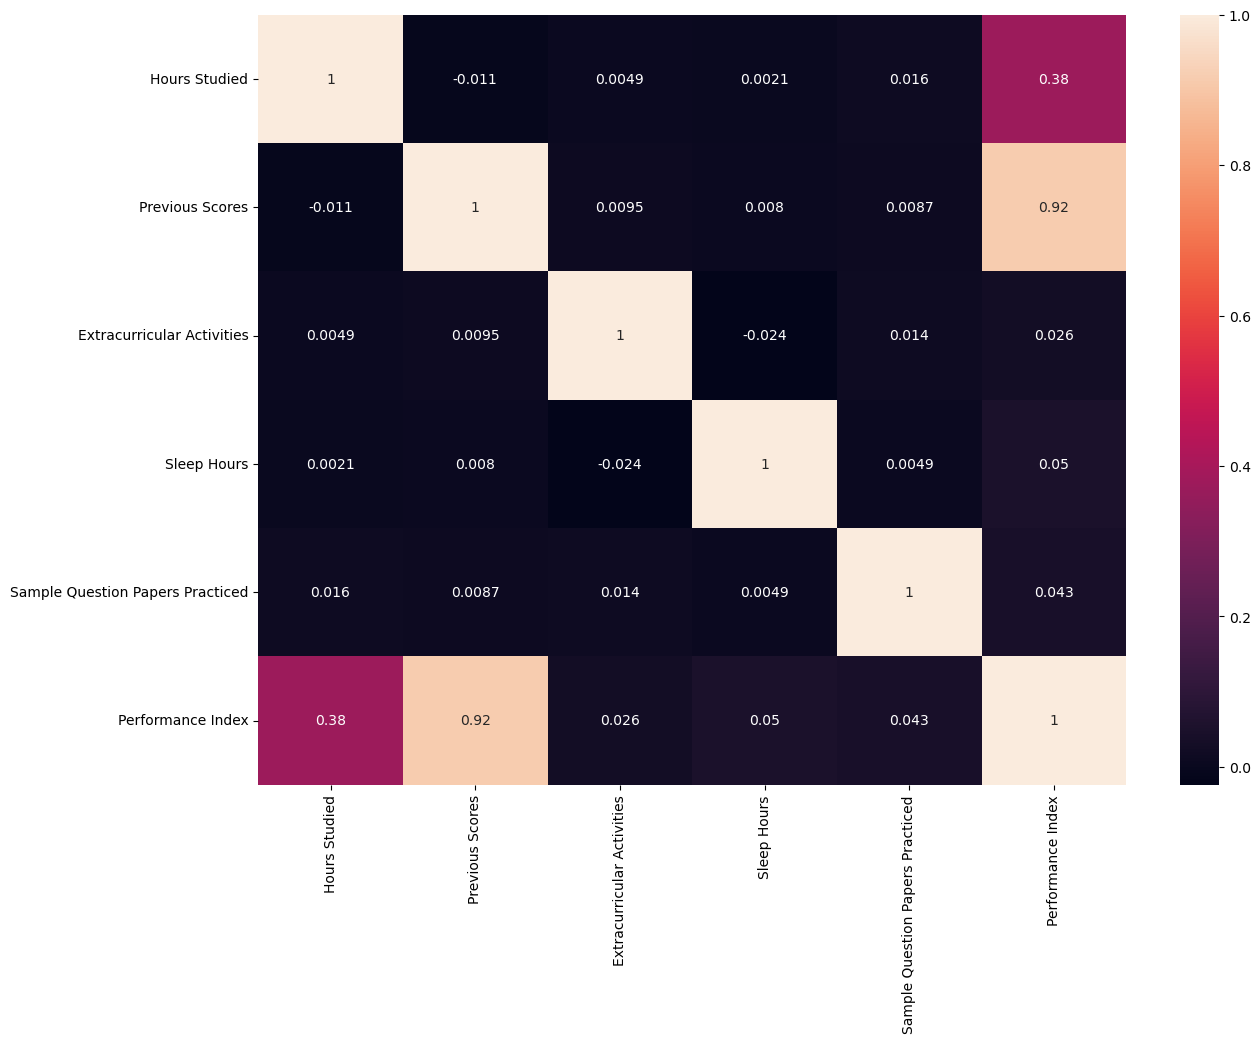

In [17]:
plt.figure(figsize=(14, 10))
relations = visual_df.corr()
sns.heatmap(data=relations,annot=True)
plt.show()

# Histogram

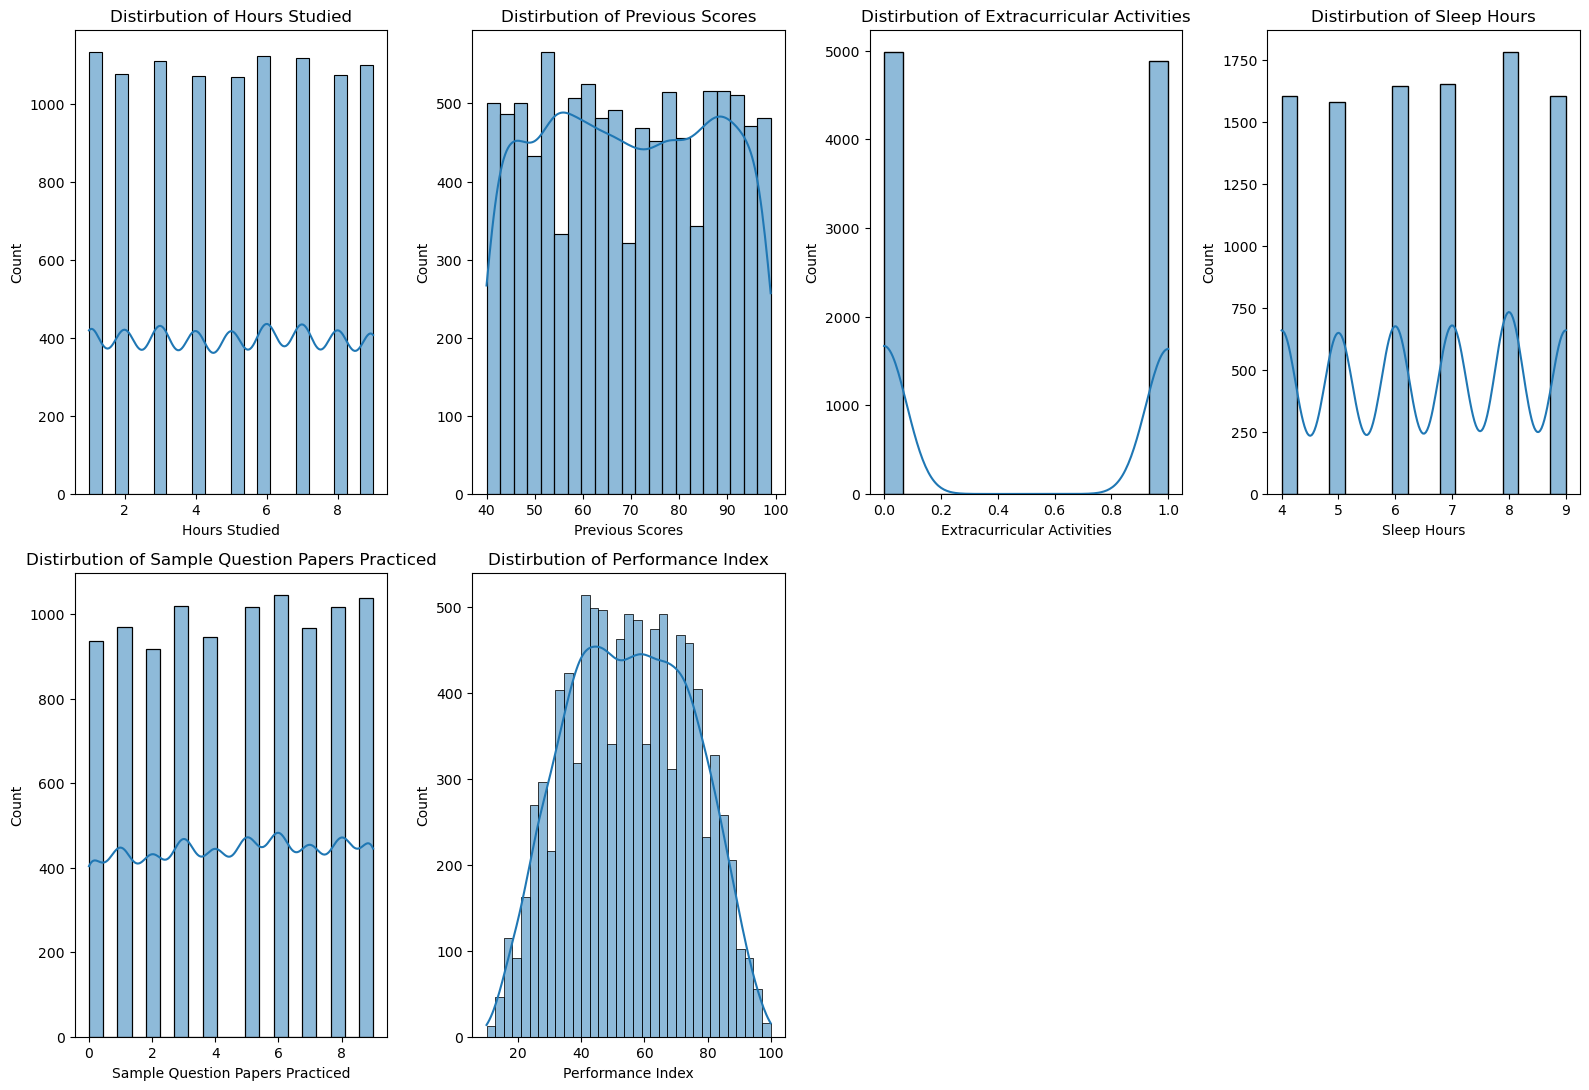

In [20]:
plot_distribution(visual_df, "hist")

# Box Plot

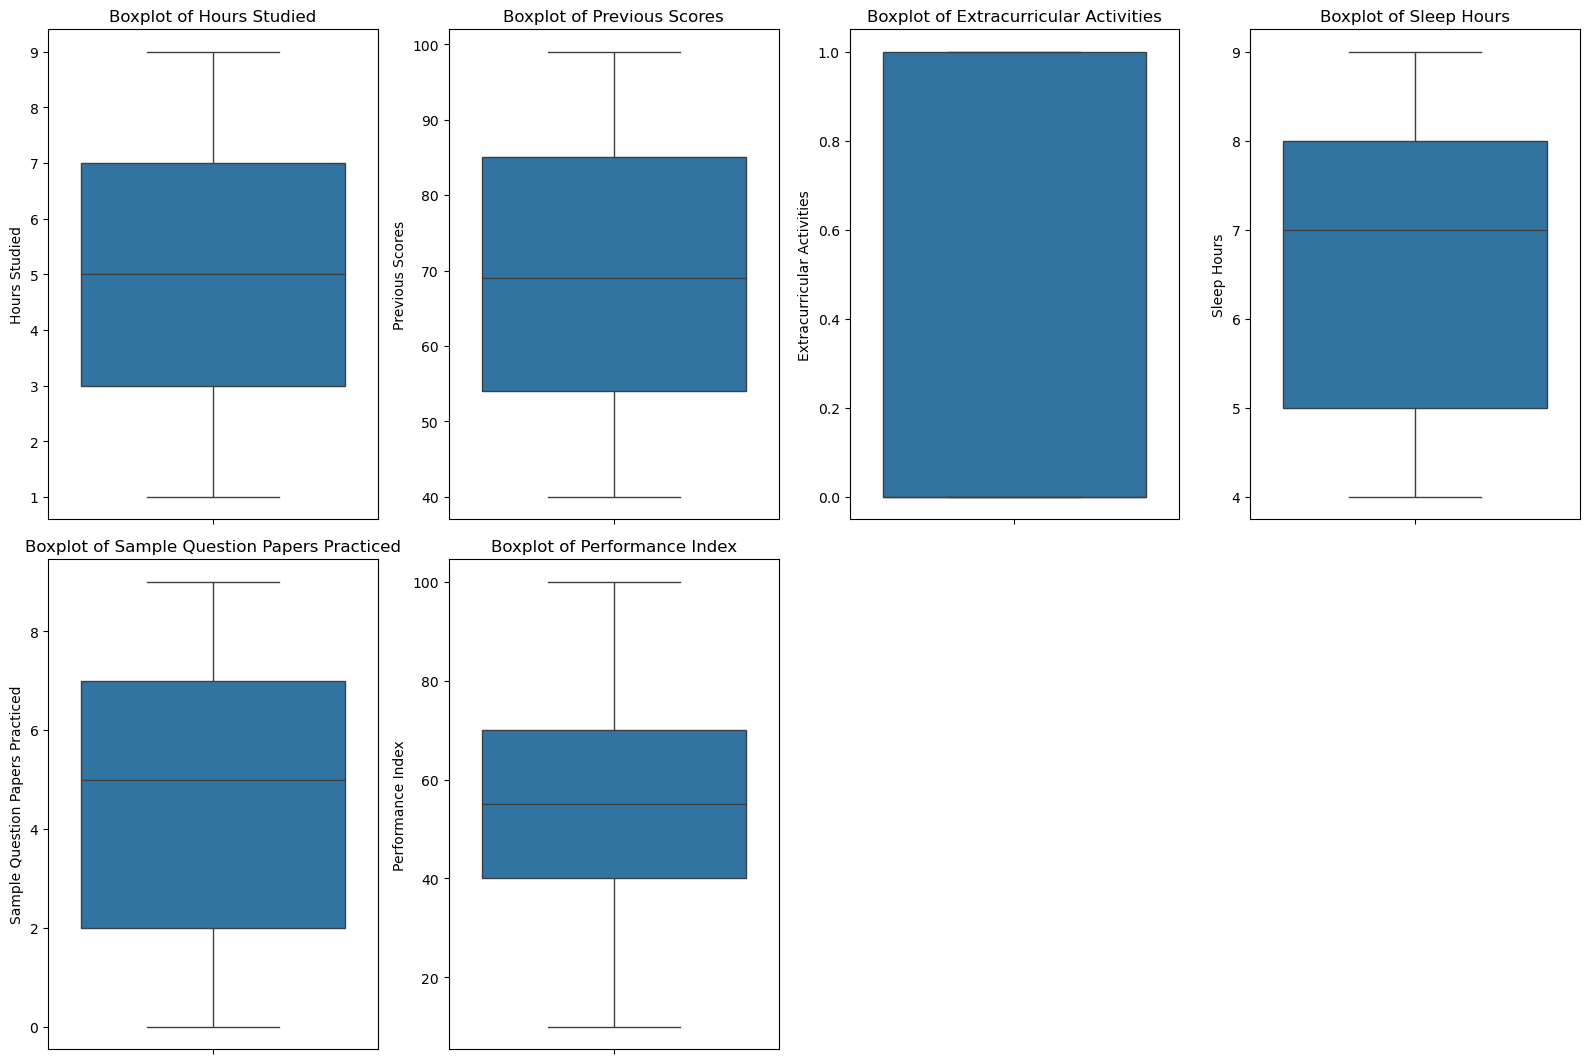

In [21]:
plot_distribution(visual_df, "box")

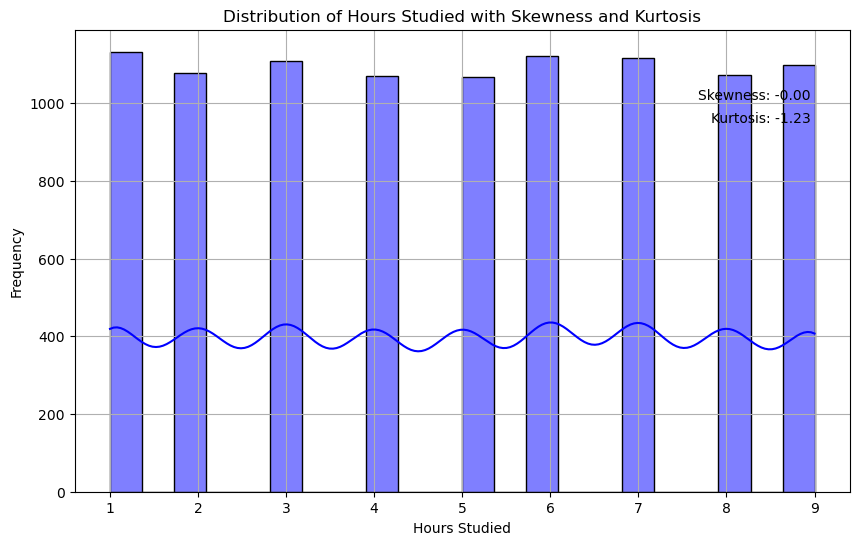

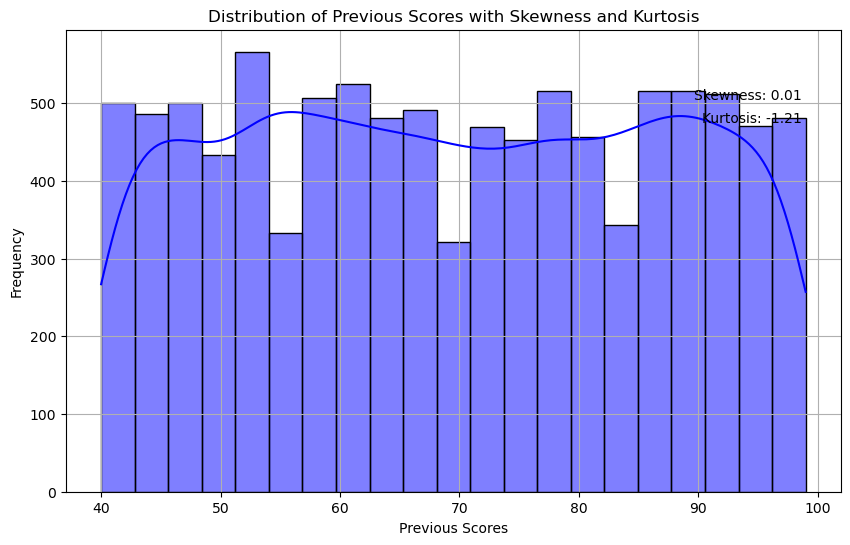

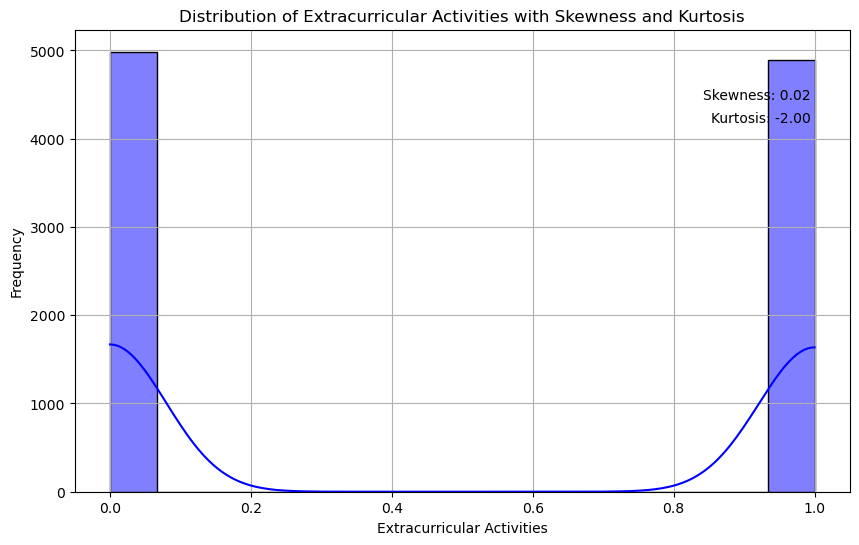

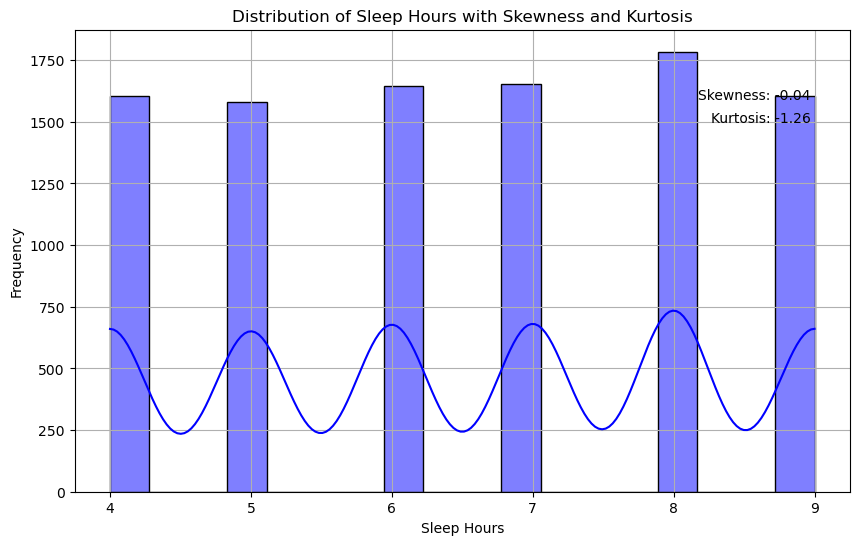

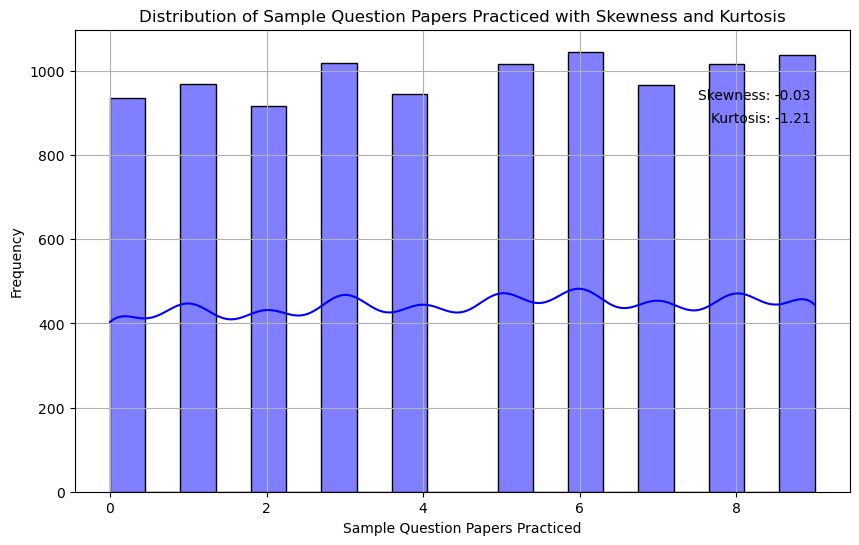

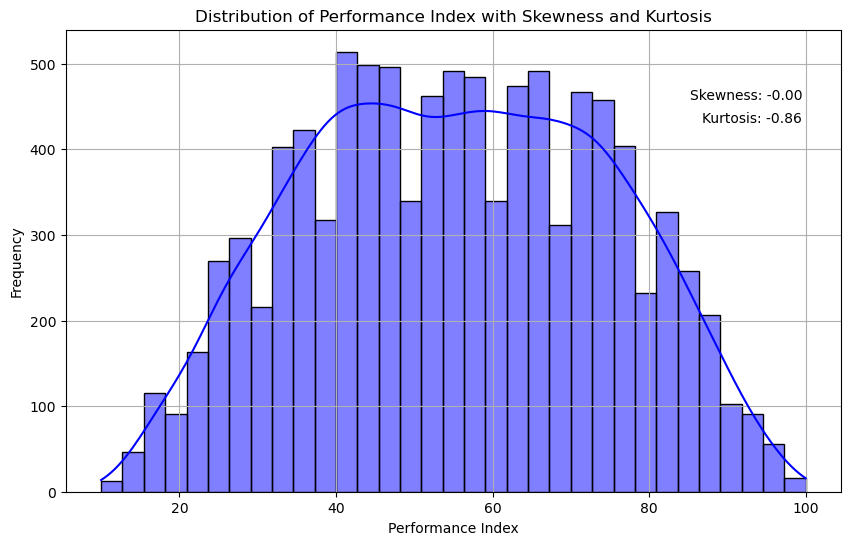

In [22]:
for col in visual_df.columns:
  dist_plot(visual_df, col)

In [36]:
visual_df["grade"] = visual_df["Performance Index"].apply(mapping_function)

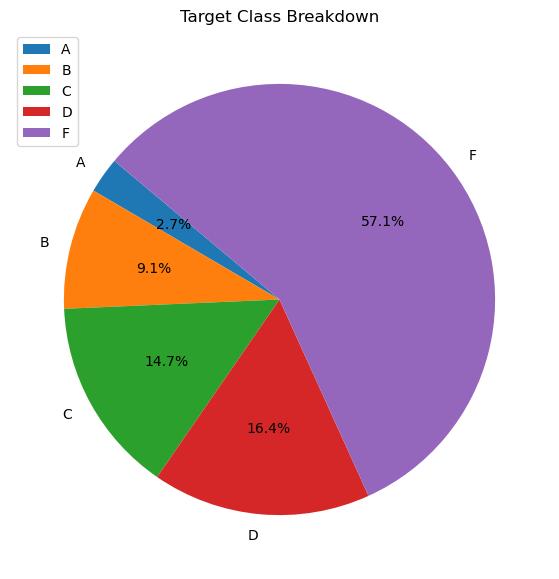

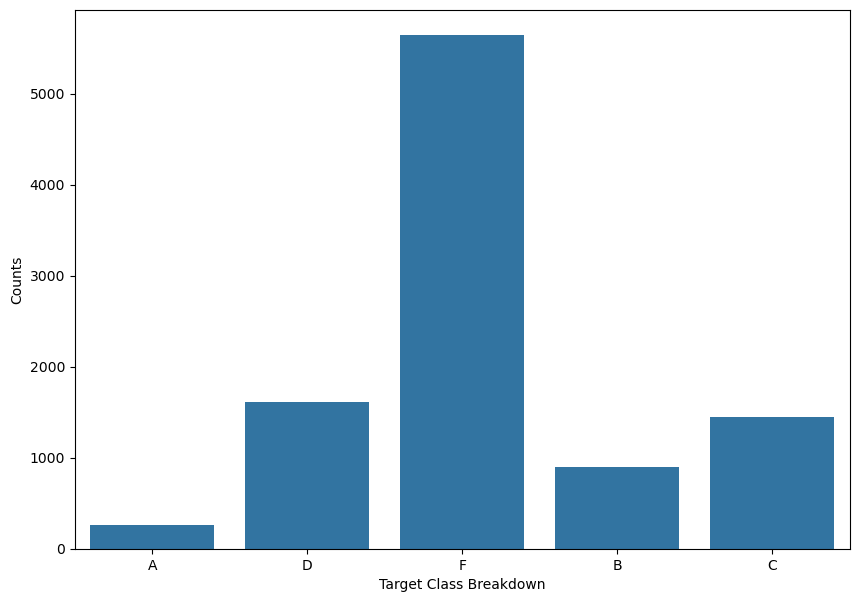

In [41]:
check_class_imbalance(visual_df["grade"])

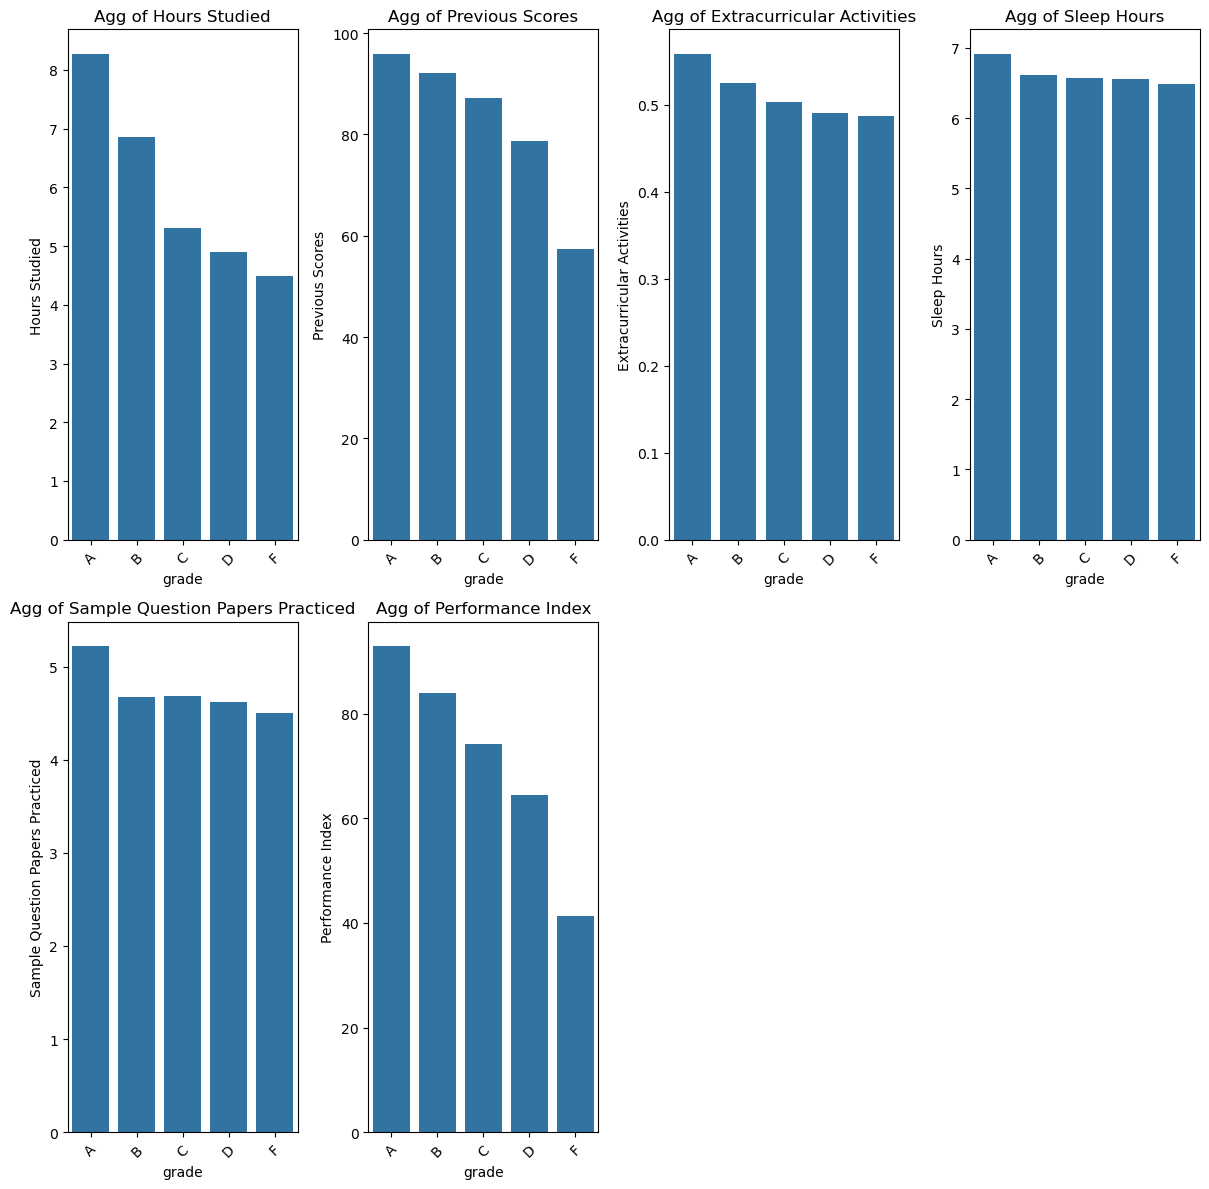

In [42]:
aggregate_dataset(visual_df, visual_df.columns, "grade", "mean")

In [54]:
best_students = visual_df[visual_df["grade"] == "A"]
worst_students = visual_df[visual_df["grade"] == "F"]

In [59]:
best_students

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,grade
0,7,99,1,9,1,91.0,A
55,6,99,0,4,7,91.0,A
61,9,97,1,8,5,98.0,A
68,9,94,0,9,1,91.0,A
87,9,99,0,4,1,95.0,A
...,...,...,...,...,...,...,...
9658,9,92,1,9,6,91.0,A
9844,8,95,0,9,6,92.0,A
9922,9,94,1,7,8,91.0,A
9976,8,93,1,9,8,91.0,A


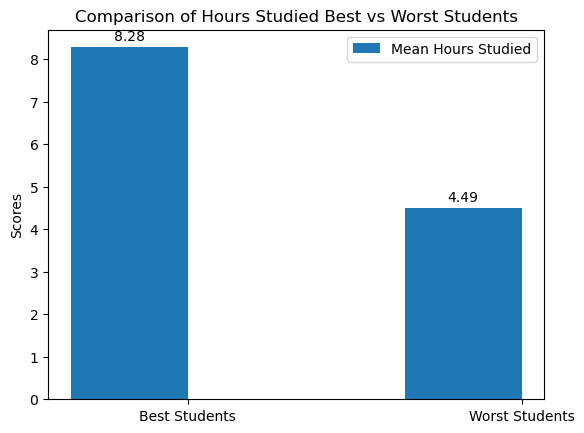

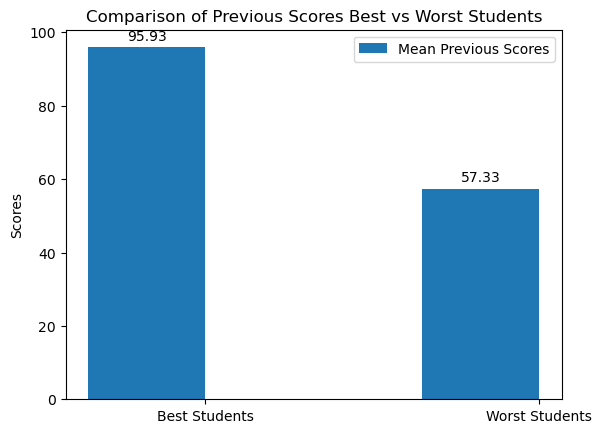

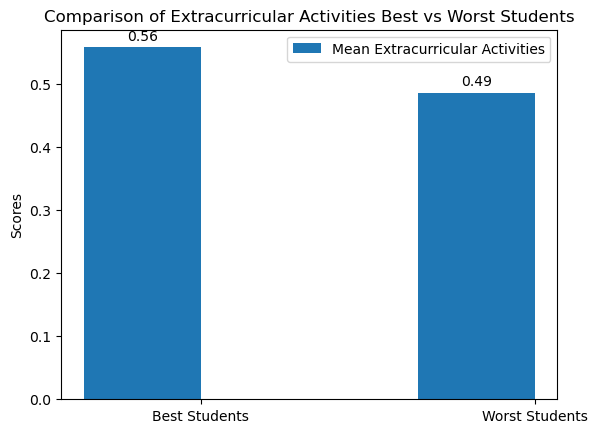

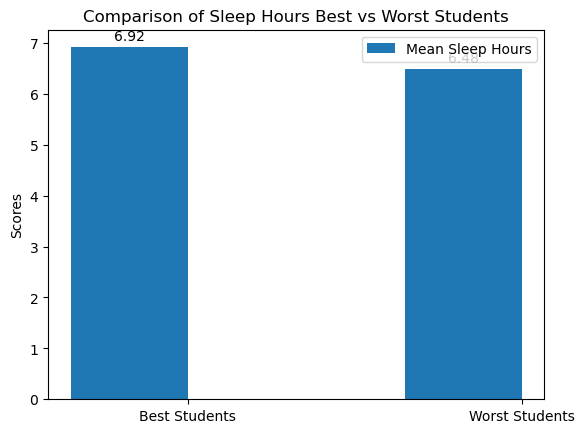

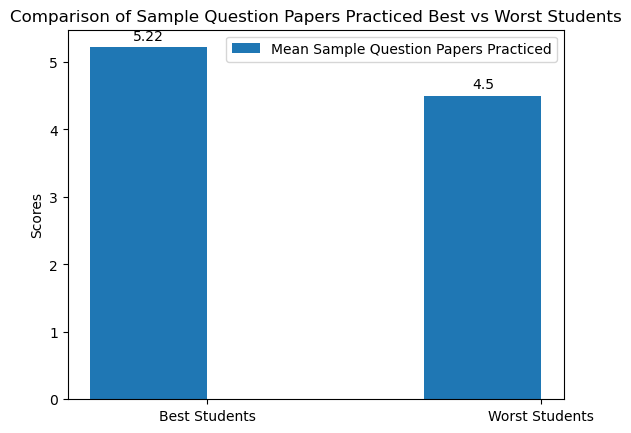

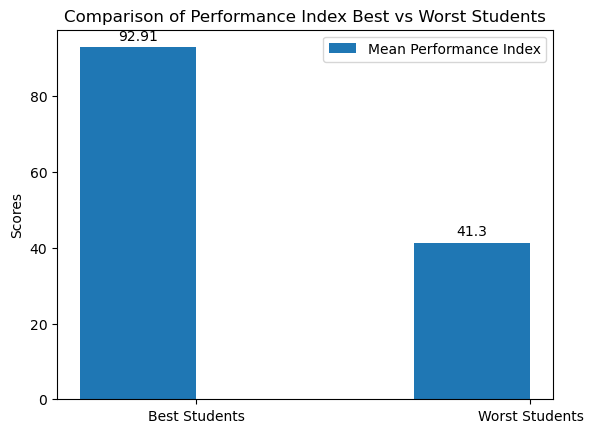

In [70]:
side_by_side(best_students, worst_students, visual_df, "grade")

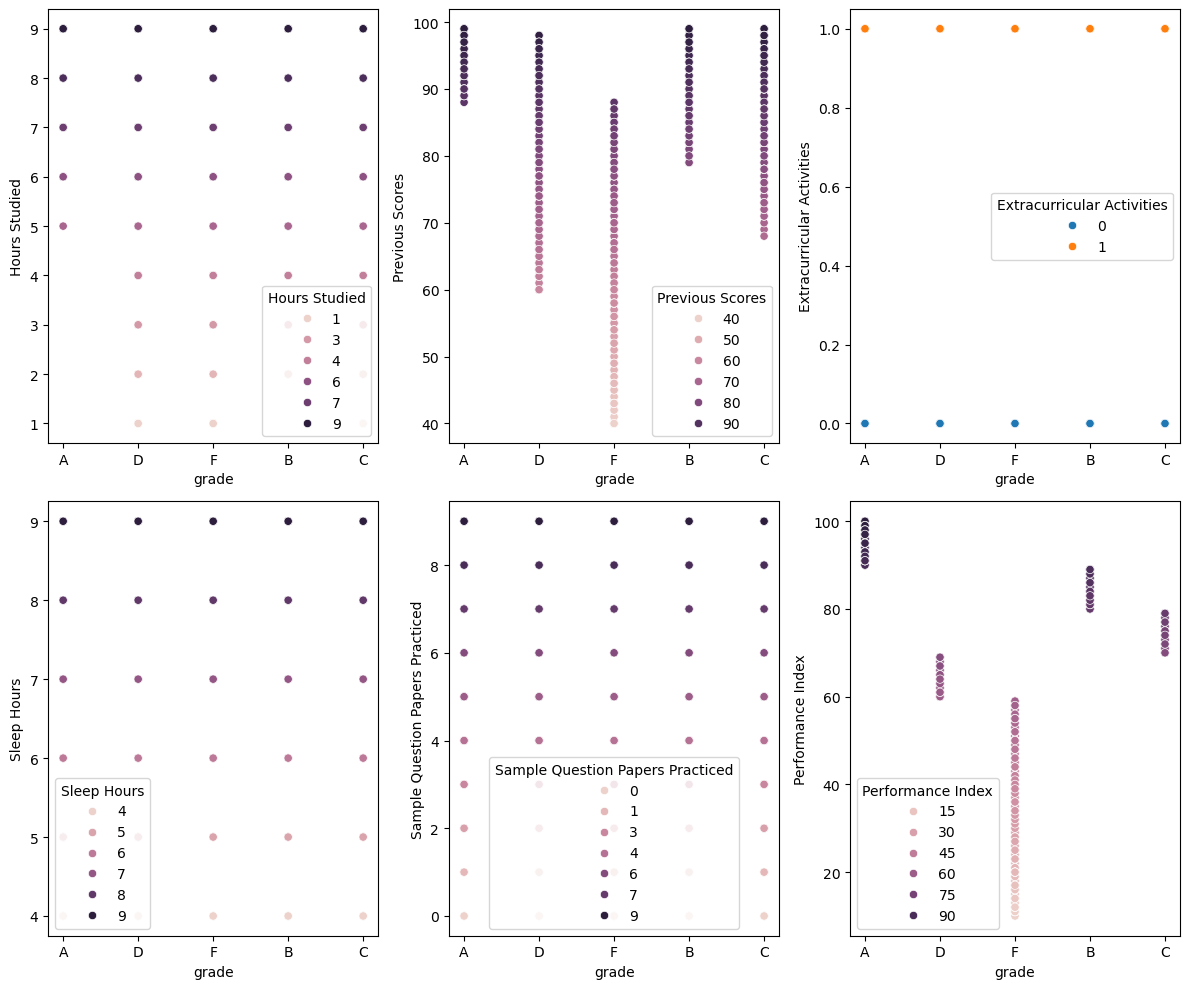

In [44]:
scatter_plot(visual_df, visual_df.columns, "grade")

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_10278/470597227.py:141: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_10278/470597227.py:141: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_10278/470597227.py:141: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
/var/folde

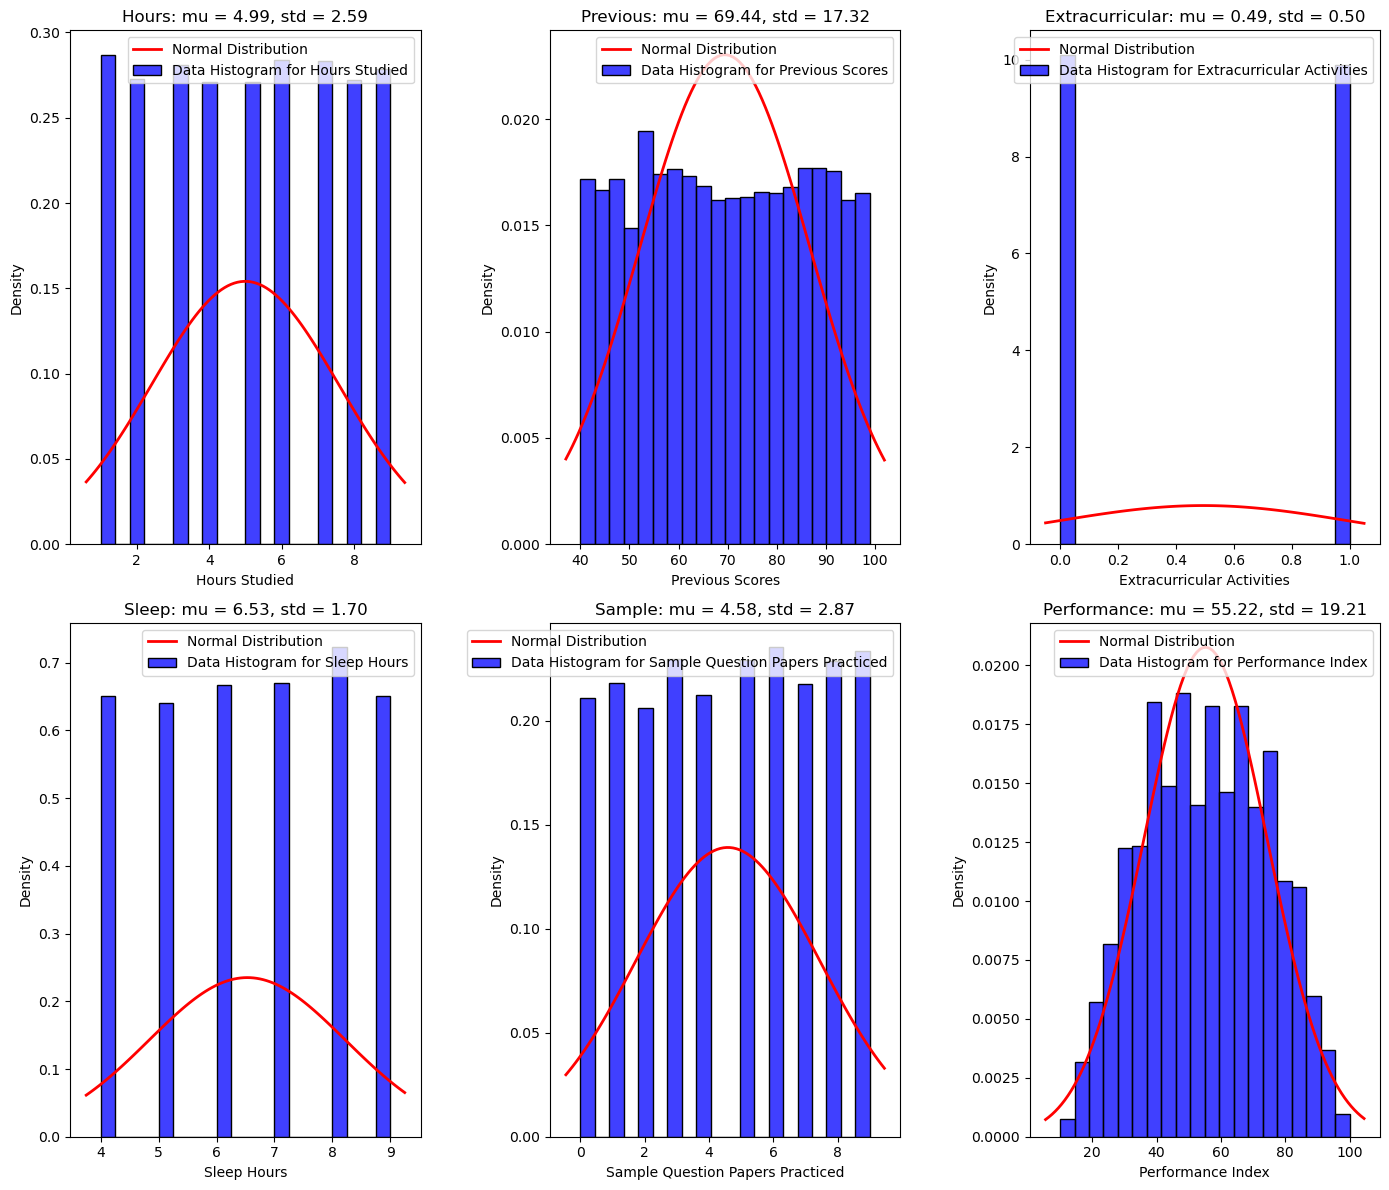

In [53]:
histogram(visual_df, visual_df.columns)